<a href="https://colab.research.google.com/github/zkatemor/thesaurus/blob/word2vec_keras_sample/dictionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install pymorphy2

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 7.1MB 9.3MB/s 


In [0]:
import pickle

In [4]:
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import collections
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Activation, Dropout
from keras.layers.embeddings import Embedding
import gensim.downloader
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import pymorphy2

Using TensorFlow backend.


# DataSet
 
Загрузка словаря RuSentilex в формате .csv
*   https://www.labinform.ru/pub/rusentilex/index.htm



In [0]:
df = pd.read_csv('drive/My Drive/coursework/rusentilex.csv')

In [6]:
df.head(3)

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive


In [7]:
len(df)

10668

In [8]:
df['tone'].value_counts()

negative    7148
positive    2774
neutral      746
Name: tone, dtype: int64

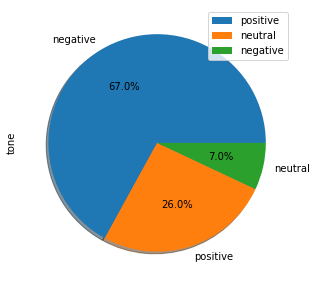

In [9]:
df['tone'].value_counts().plot(kind = 'pie',figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.legend(df['tone'].unique())
plt.show()

Всего в словаре 10668 слов.

In [0]:
# получение id тональности
def get_ids(all_tones):
    result = []

    for tone in all_tones:
        result.append(all_tones.unique().tolist().index(tone))

    return result

In [0]:
labels = get_ids(df['tone'])
total_words = df['term']
# перемешиваем
total_words, labels = sklearn.utils.shuffle(total_words, labels)

In [0]:
# добавление части речи к слову для корректной работы с русскоязычной word2vec
def add_part_of_speech(word):
    p = pymorphy2.MorphAnalyzer().parse(word)[0]
    word += '_' + str(p.tag.POS)
    return word

In [0]:
# получаем список для корректной работы с моделью
#sentences = [[add_part_of_speech(word)] for word in total_words]

with open('drive/My Drive/coursework/rusentilex_sentences.pickle', 'rb') as handle:
        sentences = pickle.load(handle)
# получаем id тональностей для сохраненного списка токенов (sentences)
with open('drive/My Drive/coursework/rusentilex_labels.pickle', 'rb') as handle:
        labels = pickle.load(handle)

In [14]:
sentences[:5]

[['толстопузость_NOUN'],
 ['винтик_NOUN'],
 ['оскорбить_INFN'],
 ['рациональный_ADJF'],
 ['равнодушный_ADJF']]

In [0]:
counter = collections.Counter()

In [0]:
#считаем максимальную длину предложений (в словаре могут быть словосочетания), а также частоту всех слов, считанных из файла
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [17]:
vocab_sz = len(counter) + 1 
print('Размер словаря: ' + str(vocab_sz))

Размер словаря: 10669


Задаем необходимые константные значения и загружаем русскоязычную модель Word2Vec

In [0]:
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
EPOCH_SIZE = 10
BATCH_SIZE = 32
NUM_FILTERS = 256
NUM_WORDS = 3

In [19]:
word2vec_model = gensim.downloader.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Работа с Keras

In [0]:
#создаём матрицу размером размерность словаря*размерность вектора слова
embedding_weights = np.zeros((vocab_sz, EMBEDDING_DIM))
index = 0
#сортируем слова по частоте встречаемости
sorted_counter = counter.most_common()
#для каждого слова из нашего словаря задаём вектор из word2vec_model в матрицу
for word in sorted_counter:
    try:
      embedding_weights[index, :] = word2vec_model[word[0]] 
      index+=1     
    #если нет слова в словаре word2vec_model
    except KeyError:
      index+=1
      pass

Собираем модель для обучения:
1 слой модели – русскоязычный word2vec

In [0]:
import keras

In [22]:
model = Sequential()
model.add(Embedding(vocab_sz, EMBEDDING_DIM, input_length=maxlen, weights=[embedding_weights],
                    trainable=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv1D(50,
                                1,
                                padding='valid',
                                activation='relu',
                                strides=1))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(250))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(3, activation='softmax'))











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 300)            3200700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 50)             15050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               12750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)              

# Train Model

Обучение модели

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
#заменяем слова каждого предложения на числа
X = tokenizer.texts_to_sequences(sentences)
#уравниваем все предложения до размера maxlen
X = pad_sequences(X, maxlen = maxlen)

In [0]:
y = to_categorical(labels)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

In [32]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, 
                    callbacks=[keras.callbacks.ModelCheckpoint('drive/My Drive/coursework/model.h5', save_best_only=True)],
                    validation_split=VALIDATION_SPLIT, verbose=2)

Train on 5973 samples, validate on 1494 samples
Epoch 1/10
 - 1s - loss: 0.3407 - acc: 0.8667 - val_loss: 0.3058 - val_acc: 0.8688
Epoch 2/10
 - 1s - loss: 0.0044 - acc: 0.9995 - val_loss: 0.3210 - val_acc: 0.8588
Epoch 3/10
 - 1s - loss: 1.4189e-04 - acc: 1.0000 - val_loss: 0.3212 - val_acc: 0.8608
Epoch 4/10
 - 1s - loss: 8.0059e-05 - acc: 1.0000 - val_loss: 0.3218 - val_acc: 0.8608
Epoch 5/10
 - 1s - loss: 5.7372e-05 - acc: 1.0000 - val_loss: 0.3223 - val_acc: 0.8608
Epoch 6/10
 - 1s - loss: 4.7028e-05 - acc: 1.0000 - val_loss: 0.3229 - val_acc: 0.8608
Epoch 7/10
 - 1s - loss: 3.5190e-05 - acc: 1.0000 - val_loss: 0.3234 - val_acc: 0.8608
Epoch 8/10
 - 1s - loss: 2.9925e-05 - acc: 1.0000 - val_loss: 0.3239 - val_acc: 0.8608
Epoch 9/10
 - 1s - loss: 2.4418e-05 - acc: 1.0000 - val_loss: 0.3244 - val_acc: 0.8608
Epoch 10/10
 - 1s - loss: 1.9363e-05 - acc: 1.0000 - val_loss: 0.3249 - val_acc: 0.8594


In [33]:
score = model.evaluate(X_test, Y_test)
print("Test accuracy: {:.3f}".format(score[1]))

3201/3201 [==============================] - 0s 45us/step
Test accuracy: 0.854


Построение графика потерь:

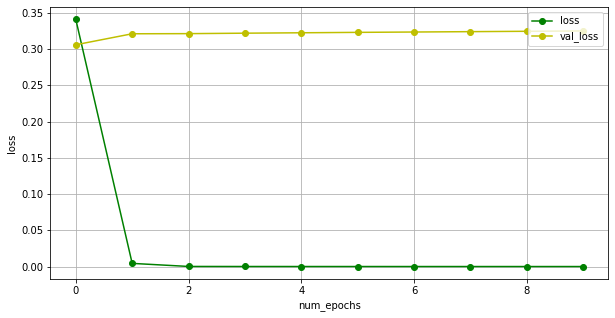

In [34]:
x = range(EPOCH_SIZE)
plt.figure(figsize = (10, 5))
plt.grid(True)
plt.plot(x, history.history['loss'], 'go-', label = 'loss')
plt.plot(x, history.history['val_loss'], 'yo-', label = 'val_loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [0]:
from keras.utils.vis_utils import plot_model

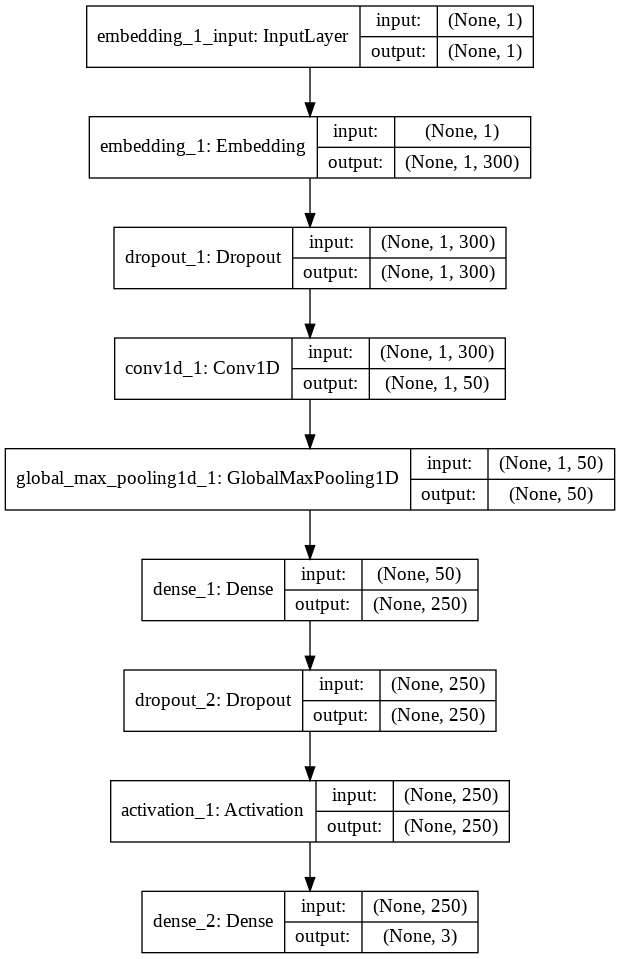

In [36]:
plot_model(model, to_file='drive/My Drive/coursework/model_plot.png', show_shapes=True, show_layer_names=True)

Отчёт по предсказанию (по разным метрикам) + матрица ошибок:

In [0]:
def from_tone(prediction, tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(tones[prediction[i]])

  return answers

In [0]:
prediction = model.predict_classes(X_test)

In [0]:
unique_tone = df['tone'].unique().tolist()

In [40]:
unique_tone

['positive', 'neutral', 'negative']

In [0]:
prediction_tones = from_tone(prediction, unique_tone) 

In [0]:
y_test = Y_test.tolist()
y_test_tones = []

for i in range(len(y_test)):
  y_test_tones.append(df['tone'].unique()[y_test[i].index(1)])

In [0]:
from sklearn.metrics import classification_report

In [44]:
print(classification_report(y_test_tones, prediction_tones))

              precision    recall  f1-score   support

    negative       0.85      0.96      0.90      2133
     neutral       0.97      0.63      0.76       233
    positive       0.85      0.66      0.74       835

    accuracy                           0.85      3201
   macro avg       0.89      0.75      0.80      3201
weighted avg       0.86      0.85      0.85      3201



In [0]:
import seaborn as sn

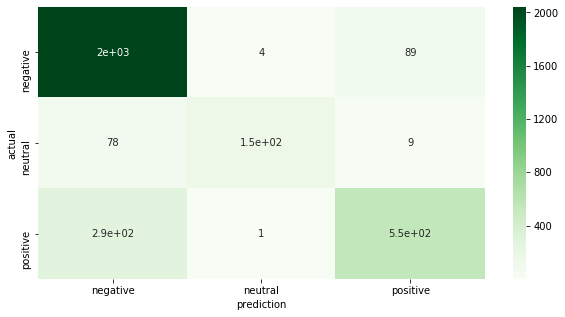

In [47]:
data = {'prediction': prediction_tones,
        'actual':    y_test_tones }

df_data = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df_data['actual'], df_data['prediction'], rownames = ['actual'], colnames = ['prediction'])
plt.figure(figsize=(10, 5))
sn.heatmap(confusion_matrix, annot=True,cmap="Greens")

Сохранение токенизированных слов и id тональностей (их построение занимает много времени, поэтому так будет проще менять структуру модели и др. в будущем)

In [0]:
#with open('drive/My Drive/coursework/rusentilex_sentences.pickle', 'wb') as f:
       # pickle.dump(sentences, f)

#with open('drive/My Drive/coursework/rusentilex_labels.pickle', 'wb') as f:
       # pickle.dump(labels, f)

# Test Model

Проверка работоспособности на небольших данных

In [0]:
# метод для преобразования из id тональности в его словесное значение (0 -> positive)
def from_tone(prediction, tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(tones[prediction[i]])

  return answers

In [0]:
test_samples = ['ненужный', 'отвратительный', 'прикольный', 'милый', 'жестокий', 'шедевр', 'никакой']

In [50]:
test_samples = [[add_part_of_speech(test)] for test in test_samples]
test_samples

[['ненужный_ADJF'],
 ['отвратительный_ADJF'],
 ['прикольный_ADJF'],
 ['милый_ADJF'],
 ['жестокий_ADJF'],
 ['шедевр_NOUN'],
 ['никакой_ADJF']]

In [0]:
test_samples_tokens = tokenizer.texts_to_sequences(test_samples)

In [0]:
test_samples_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=test_samples_pad)

In [54]:
answers = from_tone(predict, df['tone'].unique().tolist()) 
answers

['negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative']

# Классификация неразмеченного словаря, полученного из отзывов

In [0]:
import json

In [0]:
# загружаем неразмеченный словарь из json файла
with open('drive/My Drive/coursework/unallocated_dictionary.json', 'r', encoding='utf-8') as f:
    js = json.load(f)

In [57]:
js[:5]

[['телефон_NOUN', 13004],
 ['очень_ADVB', 7831],
 ['экран_NOUN', 6981],
 ['хороший_ADJF', 5305],
 ['камера_NOUN', 5178]]

In [0]:
unallocated_words = [[word[0]] for word in js]

In [59]:
unallocated_words[:6]

[['телефон_NOUN'],
 ['очень_ADVB'],
 ['экран_NOUN'],
 ['хороший_ADJF'],
 ['камера_NOUN'],
 ['весь_ADJF']]

In [0]:
unallocated_words_tokens = tokenizer.texts_to_sequences(unallocated_words)

In [0]:
unallocated_words__pad = pad_sequences(unallocated_words_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=unallocated_words__pad)

In [0]:
answers = from_tone(predict, df['tone'].unique().tolist())

In [0]:
keys = [word[0] for word in js]

In [0]:
dictionary = dict(zip(keys, answers))

In [0]:
import itertools

In [67]:
dict(itertools.islice(dictionary.items(), 15))

{'батарея_NOUN': 'negative',
 'весь_ADJF': 'negative',
 'год_NOUN': 'negative',
 'день_NOUN': 'negative',
 'камера_NOUN': 'negative',
 'качество_NOUN': 'negative',
 'один_ADJF': 'negative',
 'отличный_ADJF': 'positive',
 'очень_ADVB': 'negative',
 'приложение_NOUN': 'negative',
 'работать_INFN': 'negative',
 'телефон_NOUN': 'negative',
 'хороший_ADJF': 'positive',
 'цена_NOUN': 'negative',
 'экран_NOUN': 'negative'}

In [0]:
# сохраняем размеченный словарь в json файл
with open('drive/My Drive/coursework/tagged_dictionary_80.json', 'w', encoding='utf-8') as f:
    json.dump(dictionary, f, ensure_ascii=False, indent=4)

In [0]:
# так же сохраняем словарь в csv файл
import csv
from itertools import zip_longest
d = [keys, answers]
export_data = zip_longest(*d, fillvalue = '')
with open('drive/My Drive/coursework/tagged_dictionary_80.csv', 'w', encoding='utf-8', newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("term", "tone"))
      wr.writerows(export_data)
f.close()

In [0]:
tagged_dictionary = pd.read_csv('drive/My Drive/coursework/tagged_dictionary_80.csv')

In [71]:
tagged_dictionary[:15]

,term,tone
0,телефон_NOUN,negative
1,очень_ADVB,negative
2,экран_NOUN,negative
3,хороший_ADJF,positive
4,камера_NOUN,negative
5,весь_ADJF,negative
6,работать_INFN,negative
7,день_NOUN,negative
8,батарея_NOUN,negative
9,приложение_NOUN,negative
